# Notebook to show the Glacier model differences  (updated partly with Feb updates)

In [8]:
# # these code lines above are equal to those at the beginning of 2_glacier_vs_climate_change


# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Feb12_2024' #'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)

fill_option = 'repeat_last_101yrs'

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

try:
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    _ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    _ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)


from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models

glac_models = hue_order

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean()
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__
pd_global_temp_exp_m = get_glob_temp_exp(region='global')




['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [29]:
# select the right models and option
approach = '_via_5yravg'
_ds_reg_yr_shift= xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')
shift_years = True
if shift_years:
    add = '_shifted_to_2020'
    # we shift by maximum by +50 years, so like that there should always be values inside 
    ds_reg_yr_shift = _ds_reg_yr_shift.sel(year_after_2020=slice(0,4950))
    ds_reg_models = ds_reg_yr_shift.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
    ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
else:
    add = '_no_shift'
    ds_reg_models = _ds_reg_models_extend.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
    ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')

----

- todo: maybe use regional glacier stuff instead for the "classes" ???

In [30]:
ds_reg_models_med_vol = ds_reg_models_med_vol.assign_coords(temp_ch_ipcc= ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_med_vol.experiments, # make sure thatwe use the same experiments
                                                                                             'temp_ch_ipcc']))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_med_vol = ds_reg_models_med_vol.reset_coords()

ds_reg_models_vol = ds_reg_models_vol.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_vol.experiments, # make sure thatwe use the same experiments
                                                                                             'temp_ch_ipcc']))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_vol = ds_reg_models_vol.reset_coords()

In [32]:

# want 101-year average
ds_reg_models_vol_5000 = ds_reg_models_vol.copy()
if shift_years:
    _vol = ds_reg_models_vol_5000.isel(year_after_2020=slice(-101,-1)).volume_m3.mean(dim='year_after_2020')
else:
    _vol = ds_reg_models_vol_5000.isel(simulation_year=slice(-101,-1)).volume_m3.mean(dim='simulation_year')
ds_reg_models_vol_5000['volume_m3'] = _vol
ds_reg_models_vol_5000 = ds_reg_models_vol_5000.reset_coords()

ds_reg_models_med_vol_5000 = ds_reg_models_med_vol.copy()
if shift_years:
    _vol = ds_reg_models_med_vol_5000.isel(year_after_2020=slice(-101,-1)).volume_m3.mean(dim='year_after_2020')
else:
    _vol = ds_reg_models_med_vol_5000.isel(simulation_year=slice(-101,-1)).volume_m3.mean(dim='simulation_year')
ds_reg_models_med_vol_5000['volume_m3'] = _vol
ds_reg_models_med_vol_5000 = ds_reg_models_med_vol_5000.reset_coords()


## 1. in the equilibrium (5000-yr) state
- idea: 
    - compute for every of the 80 experiments and every RGI regions the relative volume differences to the median response
    - take all these differences and create boxplots with them!


In [33]:
if shift_years:
    ds_reg_models_med_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_med_vol_5000.volume_m3/ds_reg_models_med_vol.isel(year_after_2020=0).volume_m3
    ds_reg_models_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_vol_5000.volume_m3/ds_reg_models_vol.isel(year_after_2020=0).volume_m3
else:
    ds_reg_models_med_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_med_vol_5000.volume_m3/ds_reg_models_med_vol.isel(simulation_year=0).volume_m3
    ds_reg_models_vol_5000['relative volume change (in %)'] = 100*ds_reg_models_vol_5000.volume_m3/ds_reg_models_vol.isel(simulation_year=0).volume_m3
ds_reg_models_vol_5000['delta relative volume change (in %, to median model)'] = ds_reg_models_vol_5000['relative volume change (in %)'] - ds_reg_models_med_vol_5000['relative volume change (in %)']
min_t_r, max_t_r = ds_reg_models_vol_5000['temp_ch_ipcc'].min()*1.01, ds_reg_models_vol_5000['temp_ch_ipcc'].max()*1.01

ds_reg_models_vol_5000_test = ds_reg_models_vol_5000.copy()
np.testing.assert_allclose(ds_reg_models_vol_5000_test['delta relative volume change (in %, to median model)'], ds_reg_models_vol_5000['delta relative volume change (in %, to median model)'])

In [34]:
# remove unnecessary variables to make the stacking faster... 
#ds_reg_models_vol_5000 = ds_reg_models_vol_5000.drop('volume_m3')
#ds_reg_models_vol_5000 = ds_reg_models_vol_5000.drop('relative volume change (in %)')

In [35]:
ds_reg_models_vol_5000_unstack = ds_reg_models_vol_5000.unstack('experiments')
ref_period = '1995-2014_hist'
diff = ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model)'] - ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model)'].sel(period_scenario=ref_period)
ds_reg_models_vol_5000_unstack['delta relative volume change (in %, to median model, relative to ref period )'] = diff
ds_reg_models_vol_5000 = ds_reg_models_vol_5000_unstack.stack(experiments=['gcm','period_scenario'])

pd_reg_models_vol_5000 = ds_reg_models_vol_5000.to_dataframe()
pd_reg_models_vol_5000 = pd_reg_models_vol_5000.reset_index().dropna()

In [36]:
# compute amount of RGI regions per model 
if shift_years:
    pd_regional_sum_initial_models = ds_reg_models.sel(year_after_2020=0).to_dataframe()
else:
    pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
    
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
total_count= pd_reg_models_count.groupby('model_author').sum()

labels_l = []
labels_l_anonym = []
for j,n in enumerate((total_count/80).round(0).astype(int).loc[hue_order].values.squeeze()):
    if n==1:
        label = f'{hue_order[j]} ({n} region)'
        label_a = f'{hue_order_anonymous[j]} ({n} region)' 
    else:
        label = f'{hue_order[j]} ({n} regions)'
        label_a = f'{hue_order_anonymous[j]} ({n} regions)'
    labels_l.append(label)
    labels_l_anonym.append(label_a)

### 1a: "normal" differences

In [37]:
# create "classes" of global temp. change

T0_l, T1_l = [], []
temp_labels = []
for t0, t1 in zip([min_t_r.values, 2, 4],[2, 4, max_t_r.values]):
    temp_label = f'{t0:.1f}°C-{t1:.1f}°C'
    condi = (pd_reg_models_vol_5000.temp_ch_ipcc <=t1)&(pd_reg_models_vol_5000.temp_ch_ipcc >=t0)
    pd_reg_models_vol_5000.loc[condi, 'temp_ch_classes'] = temp_label

pd_reg_models_vol_5000['temp_ch_classes']

0           -0.2°C-2.0°C
1           -0.2°C-2.0°C
2           -0.2°C-2.0°C
3           -0.2°C-2.0°C
4           -0.2°C-2.0°C
                ...     
57035515     4.0°C-6.9°C
57035516     4.0°C-6.9°C
57035517     2.0°C-4.0°C
57035518     4.0°C-6.9°C
57035519     4.0°C-6.9°C
Name: temp_ch_classes, Length: 36439360, dtype: object

<AxesSubplot:xlabel='model_author', ylabel='delta relative volume change (in %, to median model)'>

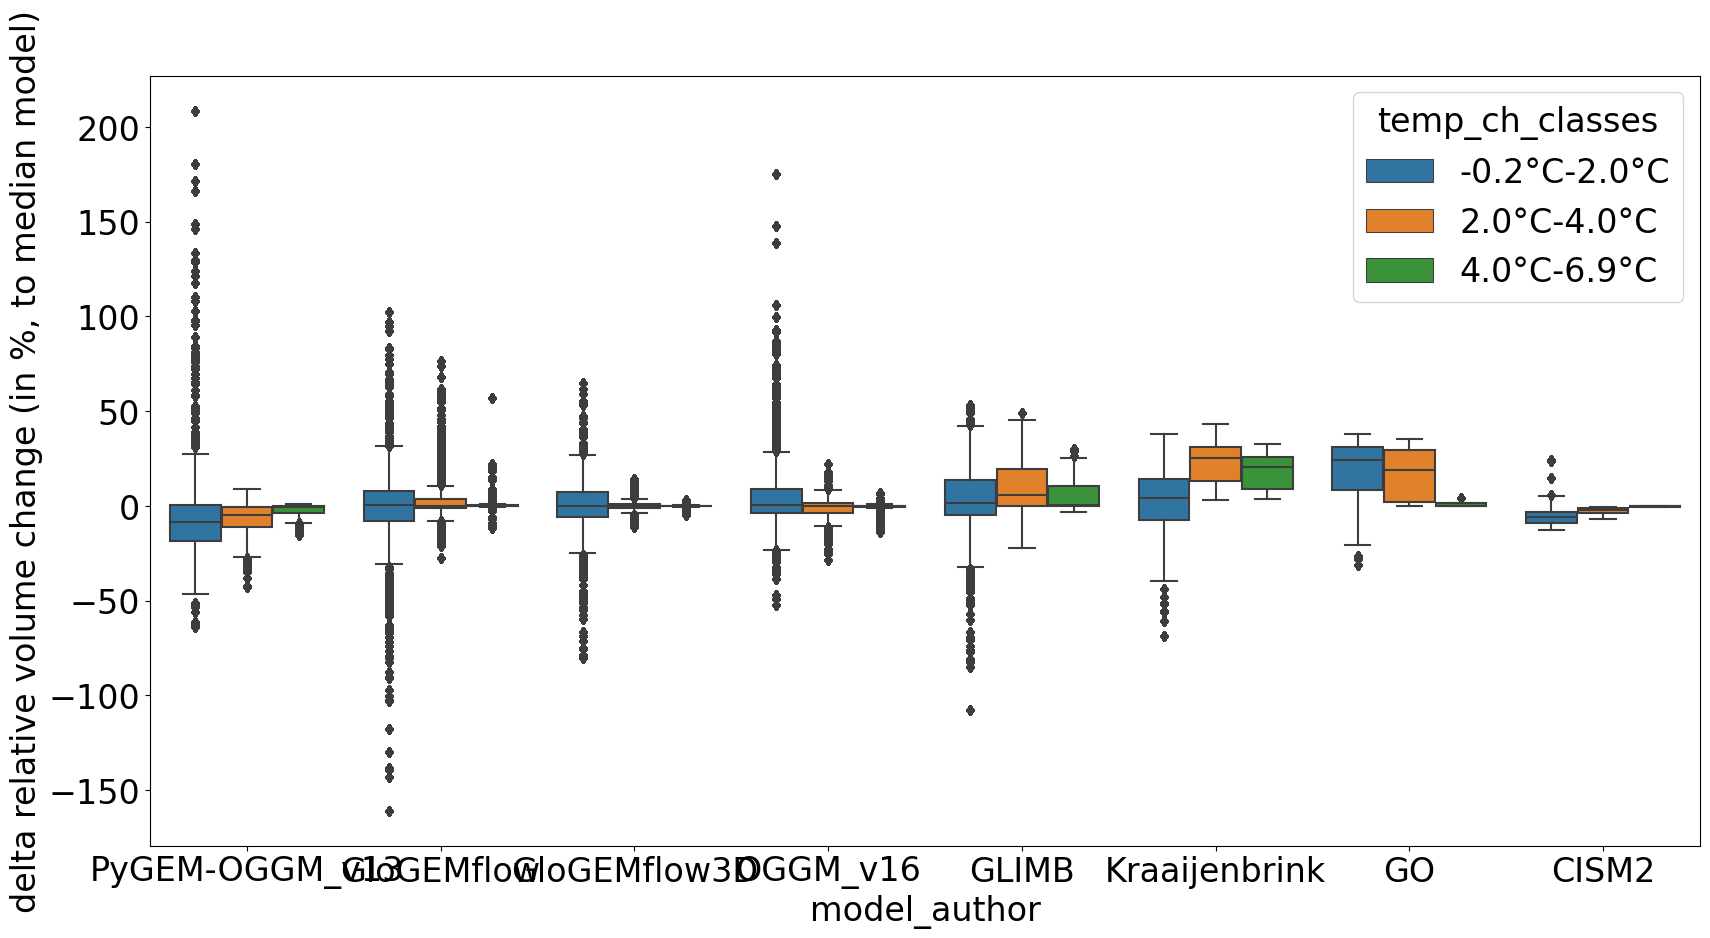

In [38]:
plt.figure(figsize=(20,10))
sns.boxplot(data=pd_reg_models_vol_5000, x='model_author', y='delta relative volume change (in %, to median model)', hue='temp_ch_classes')

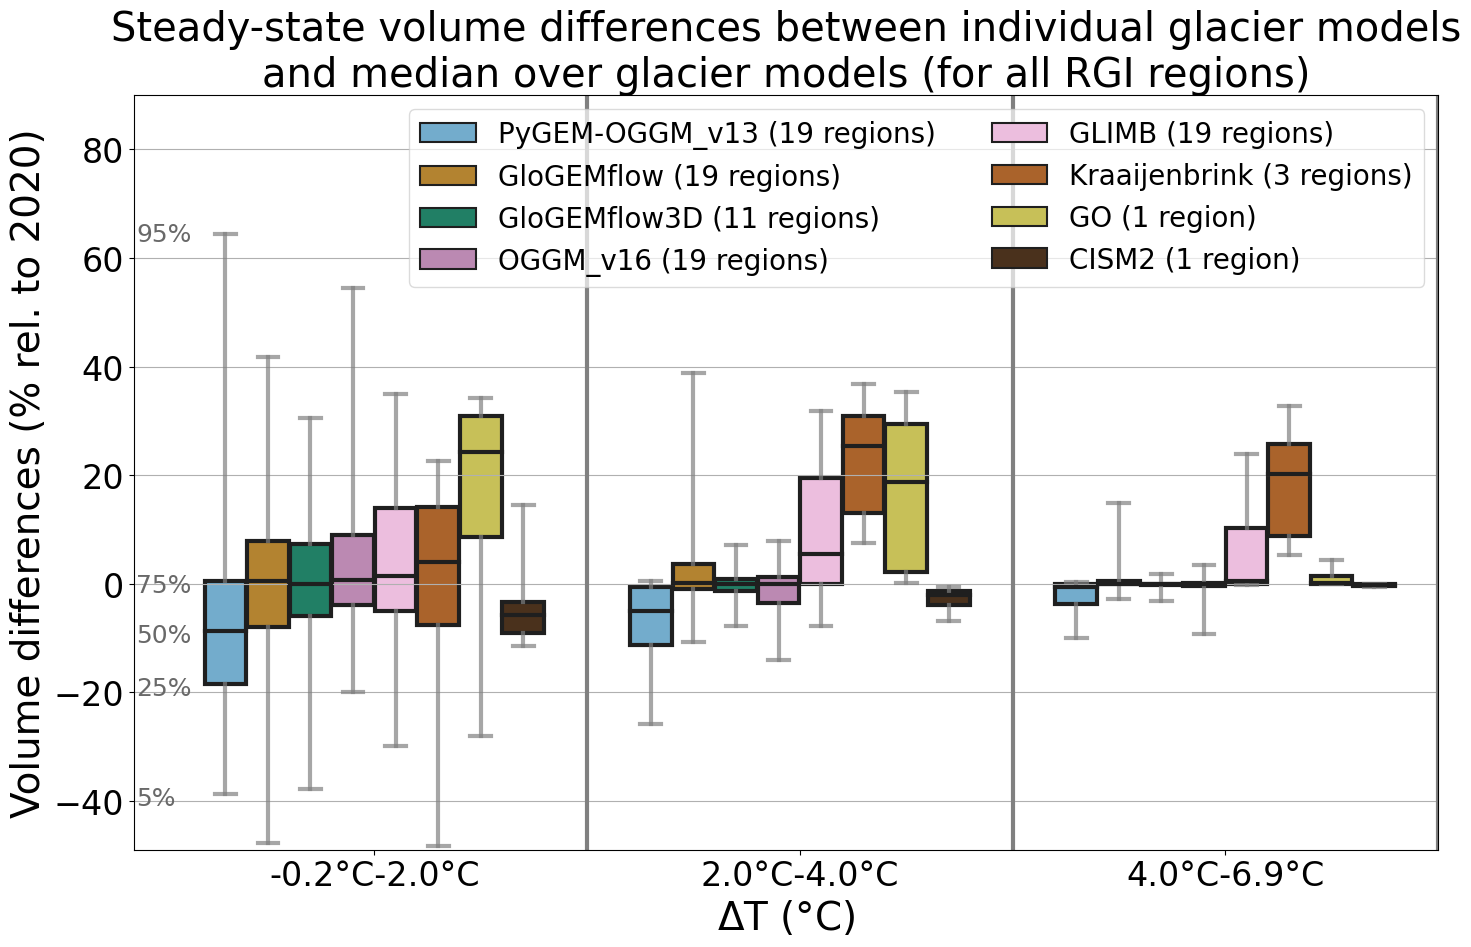

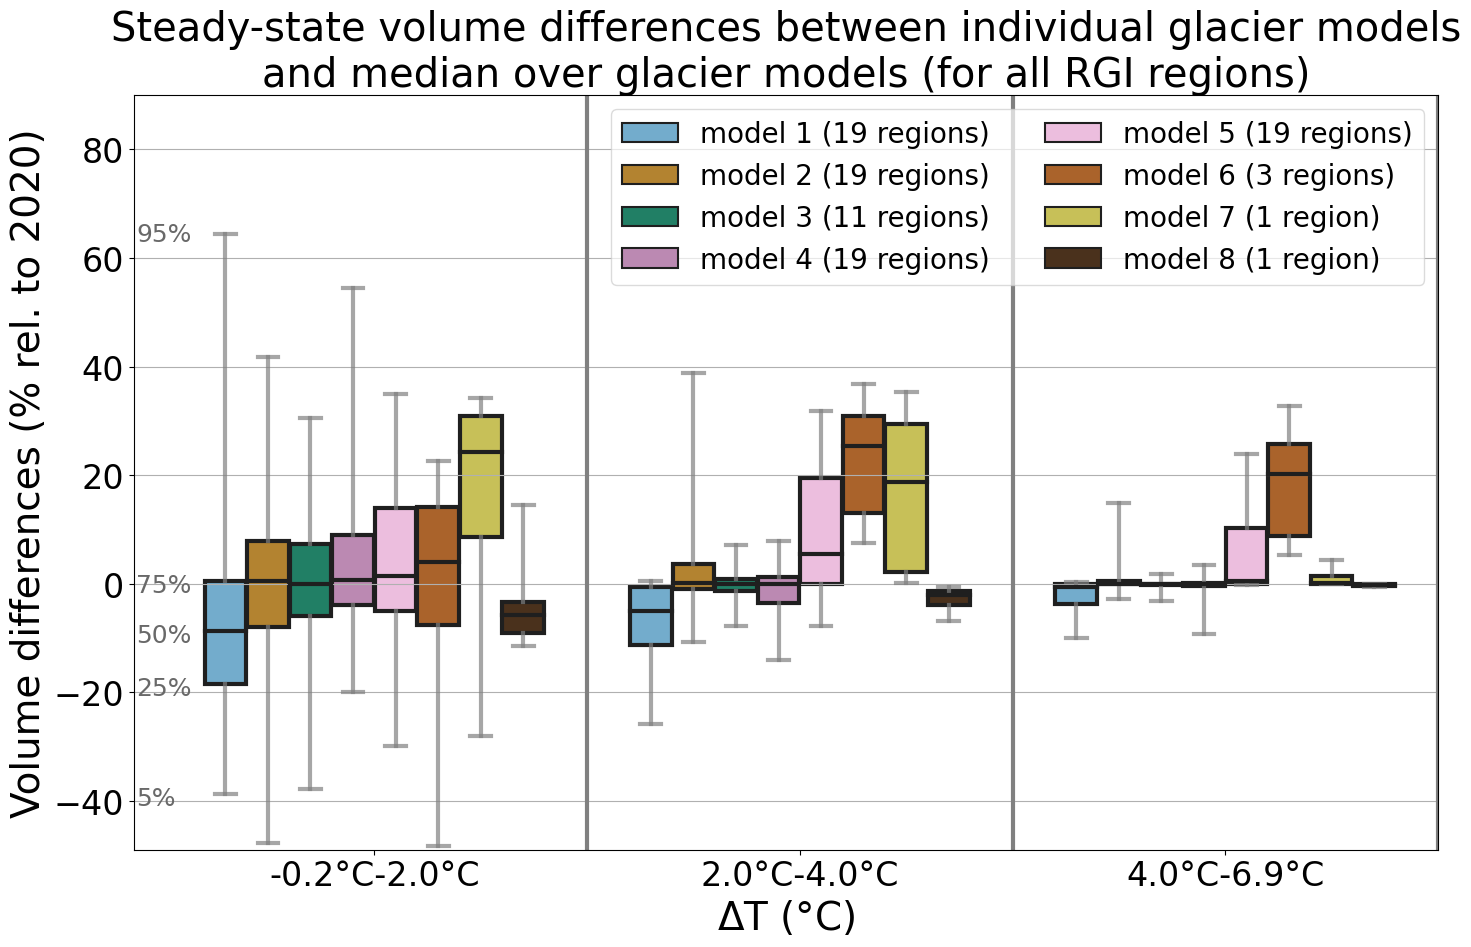

In [39]:

for anonym in ['', '_anonym']:
    plt.figure(figsize=(15,10))
    plt.rc('font', size=24)  
    sns.boxplot(data=pd_reg_models_vol_5000, hue='model_author', y='delta relative volume change (in %, to median model)',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7})
    plt.grid(axis='y')
    if shift_years:
        state = '2020'
        plt.title(f'Steady-state volume differences between individual glacier models\nand median over glacier models (for all RGI regions)')  
    else:
        state = 'initial state'
        plt.title(f'Steady-state volume differences between individual glacier models\nand median over glacier models (for all RGI regions)')  
    #plt.ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=28)
    plt.ylabel(f'Volume differences (% rel. to {state})', fontsize=28)

    plt.xlabel(r'$\Delta$T (°C)', fontsize=28) # , relative to preindustrial)
    for f in np.arange(0.5,3,1):
        plt.axvline(f, color= 'grey', ls='-', lw=3)

    ax = plt.gca()
    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    plt.ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000.groupby(['model_author', 
                                         'temp_ch_classes'])['delta relative volume change (in %, to median model)'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('PyGEM-OGGM_v13',
                                         '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    plt.xlim([-0.565,xlim1])
    plt.tight_layout()
    plt.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_model_diff_boxplot_5000yrs{anonym}_101yr_avg_period{add}_{DATE}.png')

### 2. Repeat 1. but use instead the volume differences to the reference period



In [41]:
pd_reg_models_vol_5000_no_ref_period = pd_reg_models_vol_5000.loc[pd_reg_models_vol_5000.period_scenario!=ref_period]

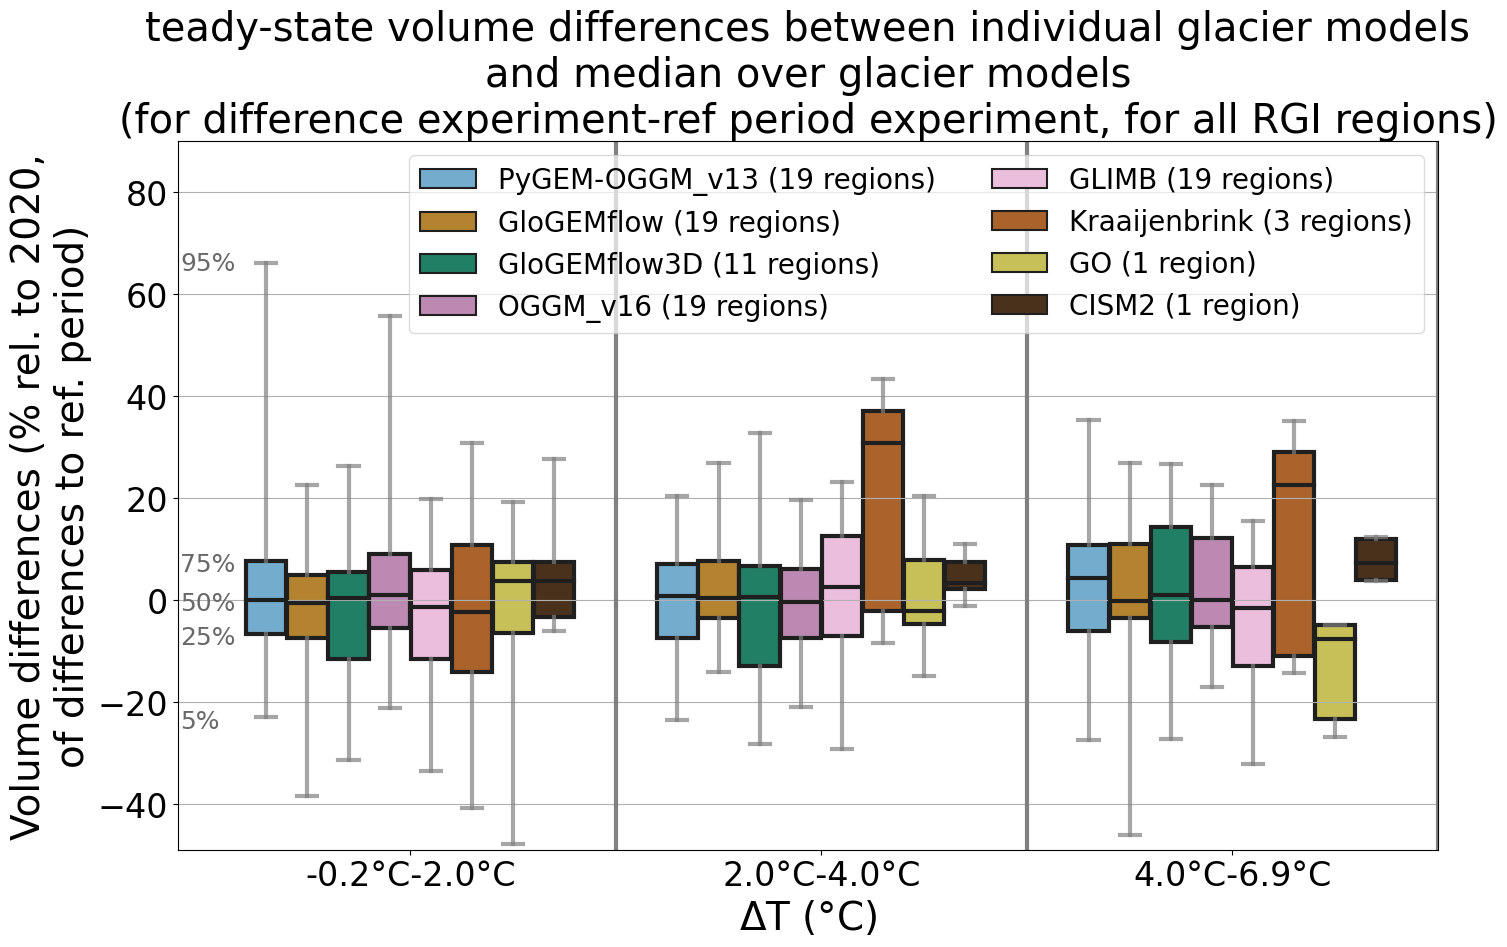

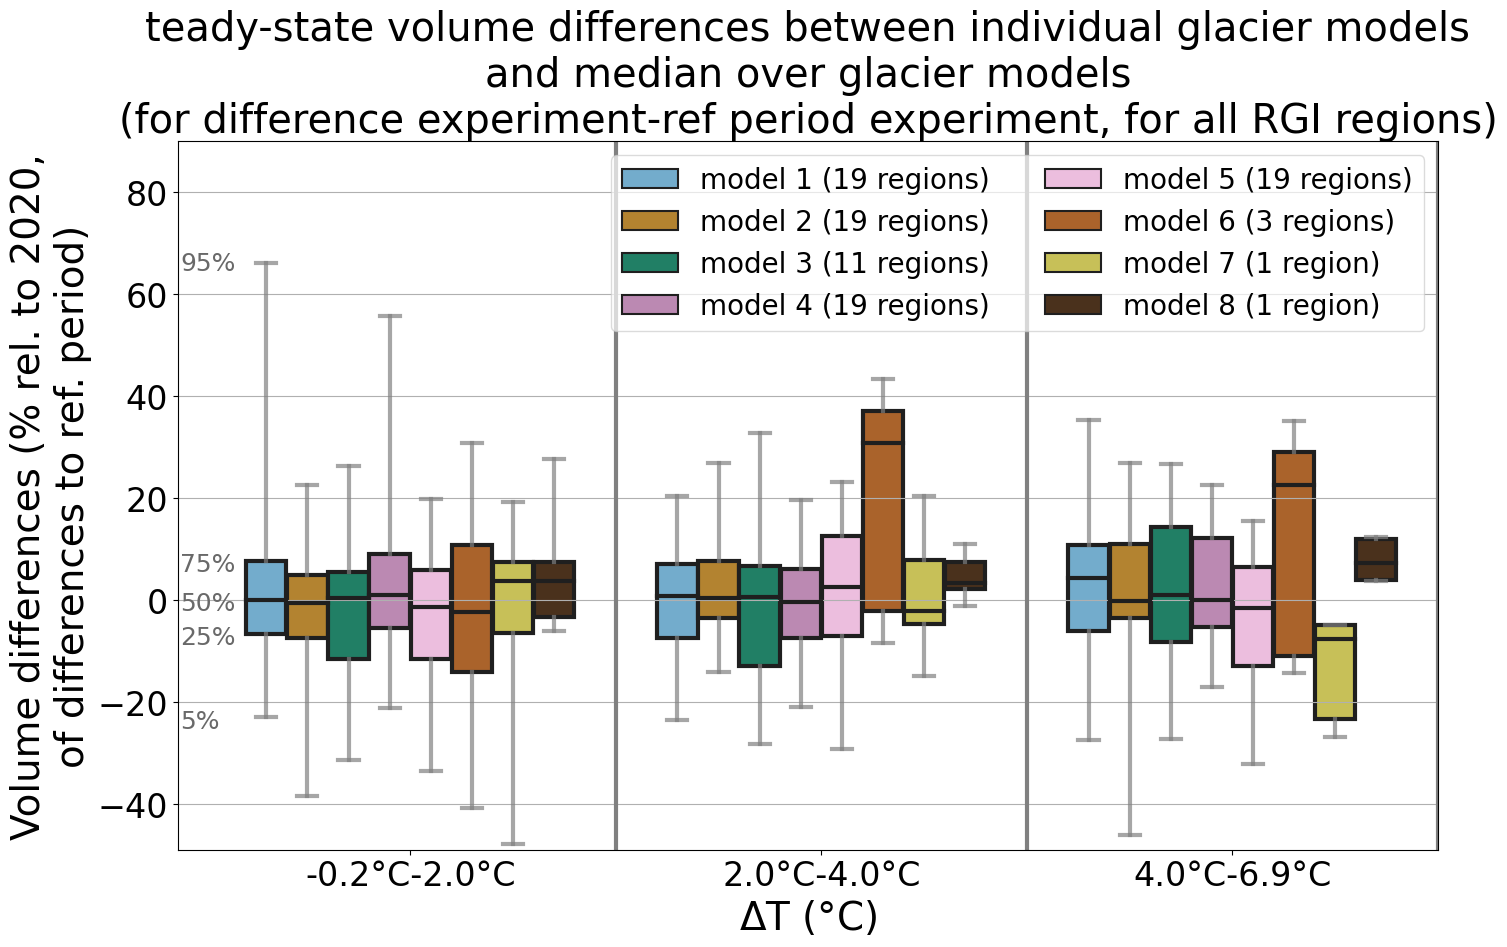

In [43]:

for anonym in ['', '_anonym']:
    plt.figure(figsize=(15,10))
    plt.rc('font', size=24)  
    sns.boxplot(data=pd_reg_models_vol_5000_no_ref_period, hue='model_author', y='delta relative volume change (in %, to median model, relative to ref period )',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},)
    plt.grid(axis='y')
    plt.title('Steady-state volume differences between individual glacier models\nand median over glacier models\n(for difference experiment-ref period experiment, for all RGI regions)')
    #plt.ylabel(r'$\Delta$V$_{rel, diff,ref-period}$ (%, difference to median model)', fontsize=26)
    #plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    #plt.title(f'Steady-state volume differences between individual glacier models\nand median over glacier models (for all RGI regions)')  
    #plt.ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=28)
    plt.ylabel(f'Volume differences (% rel. to {state},\nof differences to ref. period)', fontsize=28)

    plt.xlabel(r'$\Delta$T (°C)', fontsize=28) # , relative to preindustrial)
    
    for f in np.arange(0.5,3,1):
        plt.axvline(f, color= 'grey', ls='-', lw=3)

    ax = plt.gca()
    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    plt.ylim([-49, 90])
    
    qs = pd_reg_models_vol_5000_no_ref_period.groupby(['model_author',
                                                       'temp_ch_classes'])['delta relative volume change (in %, to median model, relative to ref period )'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('PyGEM-OGGM_v13', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,50,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    xlim0,xlim1 = ax.get_xlim()
    plt.xlim([-0.565,xlim1])
    plt.tight_layout()
    plt.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_model_diff_to_ref_period_boxplot_5000yrs{anonym}_101yr_avg_period{add}_{DATE}.png')

In [49]:
# both together
# this would need to be updated ... 
old = False
if old:
    for anonym in ['', '_anonym']:
        fig, axs = plt.subplots(1,2,figsize=(28,12),sharey=False, sharex=True)
        plt.rc('font', size=24)  
        ##########
        ax = axs[0]
        sns.boxplot(data=pd_reg_models_vol_5000, hue='model_author', y='delta relative volume change (in %, to median model)',
                    x='temp_ch_classes', palette=pal_models, saturation=0.6,
                   hue_order=hue_order, dodge = True, #hue='ssp',
                                        fliersize=0, whis = [5,95], 
                                        #y = 'time', #hue_order = ['2040', '2100'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7},ax=ax)
        ax.grid(axis='y')
        ax.set_title('Volume differences to median glacier model estimate\n(after 5000 years, relative to initial state, for all RGI regions)')
        ax.set_ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=26)
        ax.set_xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
        for f in np.arange(0.5,3,1):
            ax.axvline(f, color= 'grey', ls='-', lw=3)

        _leg = ax.get_legend()
        handles, labels = ax.get_legend_handles_labels()
        _leg.remove()
        #n = len(hue_order)
        if anonym=='_anonym':
            leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        else:
            leg = ax.legend(handles, labels_l, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        ax.set_ylim([-49, 90])

        qs = pd_reg_models_vol_5000.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model)'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci <=75:
                ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
            else:
                ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
        xlim0,xlim1 = ax.get_xlim()
        ax.set_xlim([-0.565,xlim1])


        #############
        ax = axs[1]
        sns.boxplot(data=pd_reg_models_vol_5000_no_ref_period, hue='model_author', y='delta relative volume change (in %, to median model, relative to ref period )',
                    x='temp_ch_classes', palette=pal_models, saturation=0.6,
                   hue_order=hue_order, dodge = True, #hue='ssp',
                                        fliersize=0, whis = [5,95], 
                                        #y = 'time', #hue_order = ['2040', '2100'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7},ax=ax)
        ax.grid(axis='y')
        ax.set_title('Volume differences to median glacier model estimate\n(for difference of experiment-ref period experiment,\nafter 5000 years, relative to initial state, for all RGI regions)')
        ax.set_ylabel(r'$\Delta$V$_{rel, diff,ref-period}$ (%, difference to median model)', fontsize=26)
        ax.set_xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
        for f in np.arange(0.5,3,1):
            ax.axvline(f, color= 'grey', ls='-', lw=3)

        _leg = ax.get_legend()
        handles, labels = ax.get_legend_handles_labels()
        _leg.remove()
        #n = len(hue_order)
        if anonym=='_anonym':
            leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        else:
            leg = ax.legend(handles, labels_l, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        leg.remove()
        ax.set_ylim([-49, 90])

        qs = pd_reg_models_vol_5000_no_ref_period.groupby(['model_author', 'temp_ch_classes'])['delta relative volume change (in %, to median model, relative to ref period )'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci <=75:
                ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
            else:
                ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
        xlim0,xlim1 = ax.get_xlim()
        ax.set_xlim([-0.565,xlim1])
        plt.tight_layout()
        plt.savefig(f'figures/3_glacier_model_eq_differences/3_glacier_model_diff_and_diff_to_ref_period_boxplot_5000yrs{anonym}_20yr_avg_period.png')

In [48]:
labels_l

['PyGEM-OGGM_v13 (19 regions)',
 'GloGEMflow (19 regions)',
 'GloGEMflow3D (11 regions)',
 'OGGM_v16 (19 regions)',
 'GLIMB (19 regions)',
 'Kraaijenbrink (3 regions)',
 'GO (1 region)',
 'CISM2 (1 region)']

## Now repeat for specific RGI regions:

In [63]:
subplots = True

In [67]:
pd_reg_models_vol_5000

,model_author,rgi_reg,year_after_2020,gcm,period_scenario,temp_ch_ipcc,volume_m3,relative volume change (in %),"delta relative volume change (in %, to median model)","delta relative volume change (in %, to median model, relative to ref period )",temp_ch_classes
0,PyGEM-OGGM_v13,01,0.0,gfdl-esm4,1851-1870_hist,0.171409,1.120602e+13,61.975613,-18.064556,0.620409,-0.2°C-2.0°C
1,PyGEM-OGGM_v13,01,0.0,gfdl-esm4,1901-1920_hist,0.418289,9.103312e+12,50.328296,-19.318514,-0.633549,-0.2°C-2.0°C
2,PyGEM-OGGM_v13,01,0.0,gfdl-esm4,1951-1970_hist,0.332281,1.045452e+13,57.860911,-16.161149,2.523816,-0.2°C-2.0°C
3,PyGEM-OGGM_v13,01,0.0,gfdl-esm4,1995-2014_hist,0.841467,8.751563e+12,48.359857,-18.684965,0.000000,-0.2°C-2.0°C
4,PyGEM-OGGM_v13,01,0.0,gfdl-esm4,2021-2040_ssp126,1.433792,6.114178e+12,34.040648,-19.796189,-1.111224,-0.2°C-2.0°C
...,...,...,...,...,...,...,...,...,...,...,...
57035515,CISM2,11,4950.0,ukesm1-0-ll,2061-2080_ssp370,4.379977,2.282390e+08,0.230853,-0.271691,3.702509,4.0°C-6.9°C
57035516,CISM2,11,4950.0,ukesm1-0-ll,2061-2080_ssp585,5.170543,3.317951e+07,0.033679,-0.102246,3.871955,4.0°C-6.9°C
57035517,CISM2,11,4950.0,ukesm1-0-ll,2081-2100_ssp126,2.978482,2.965017e+09,3.143693,-1.331851,2.642349,2.0°C-4.0°C
57035518,CISM2,11,4950.0,ukesm1-0-ll,2081-2100_ssp370,5.780495,2.100612e+07,0.021713,-0.053247,3.920953,4.0°C-6.9°C


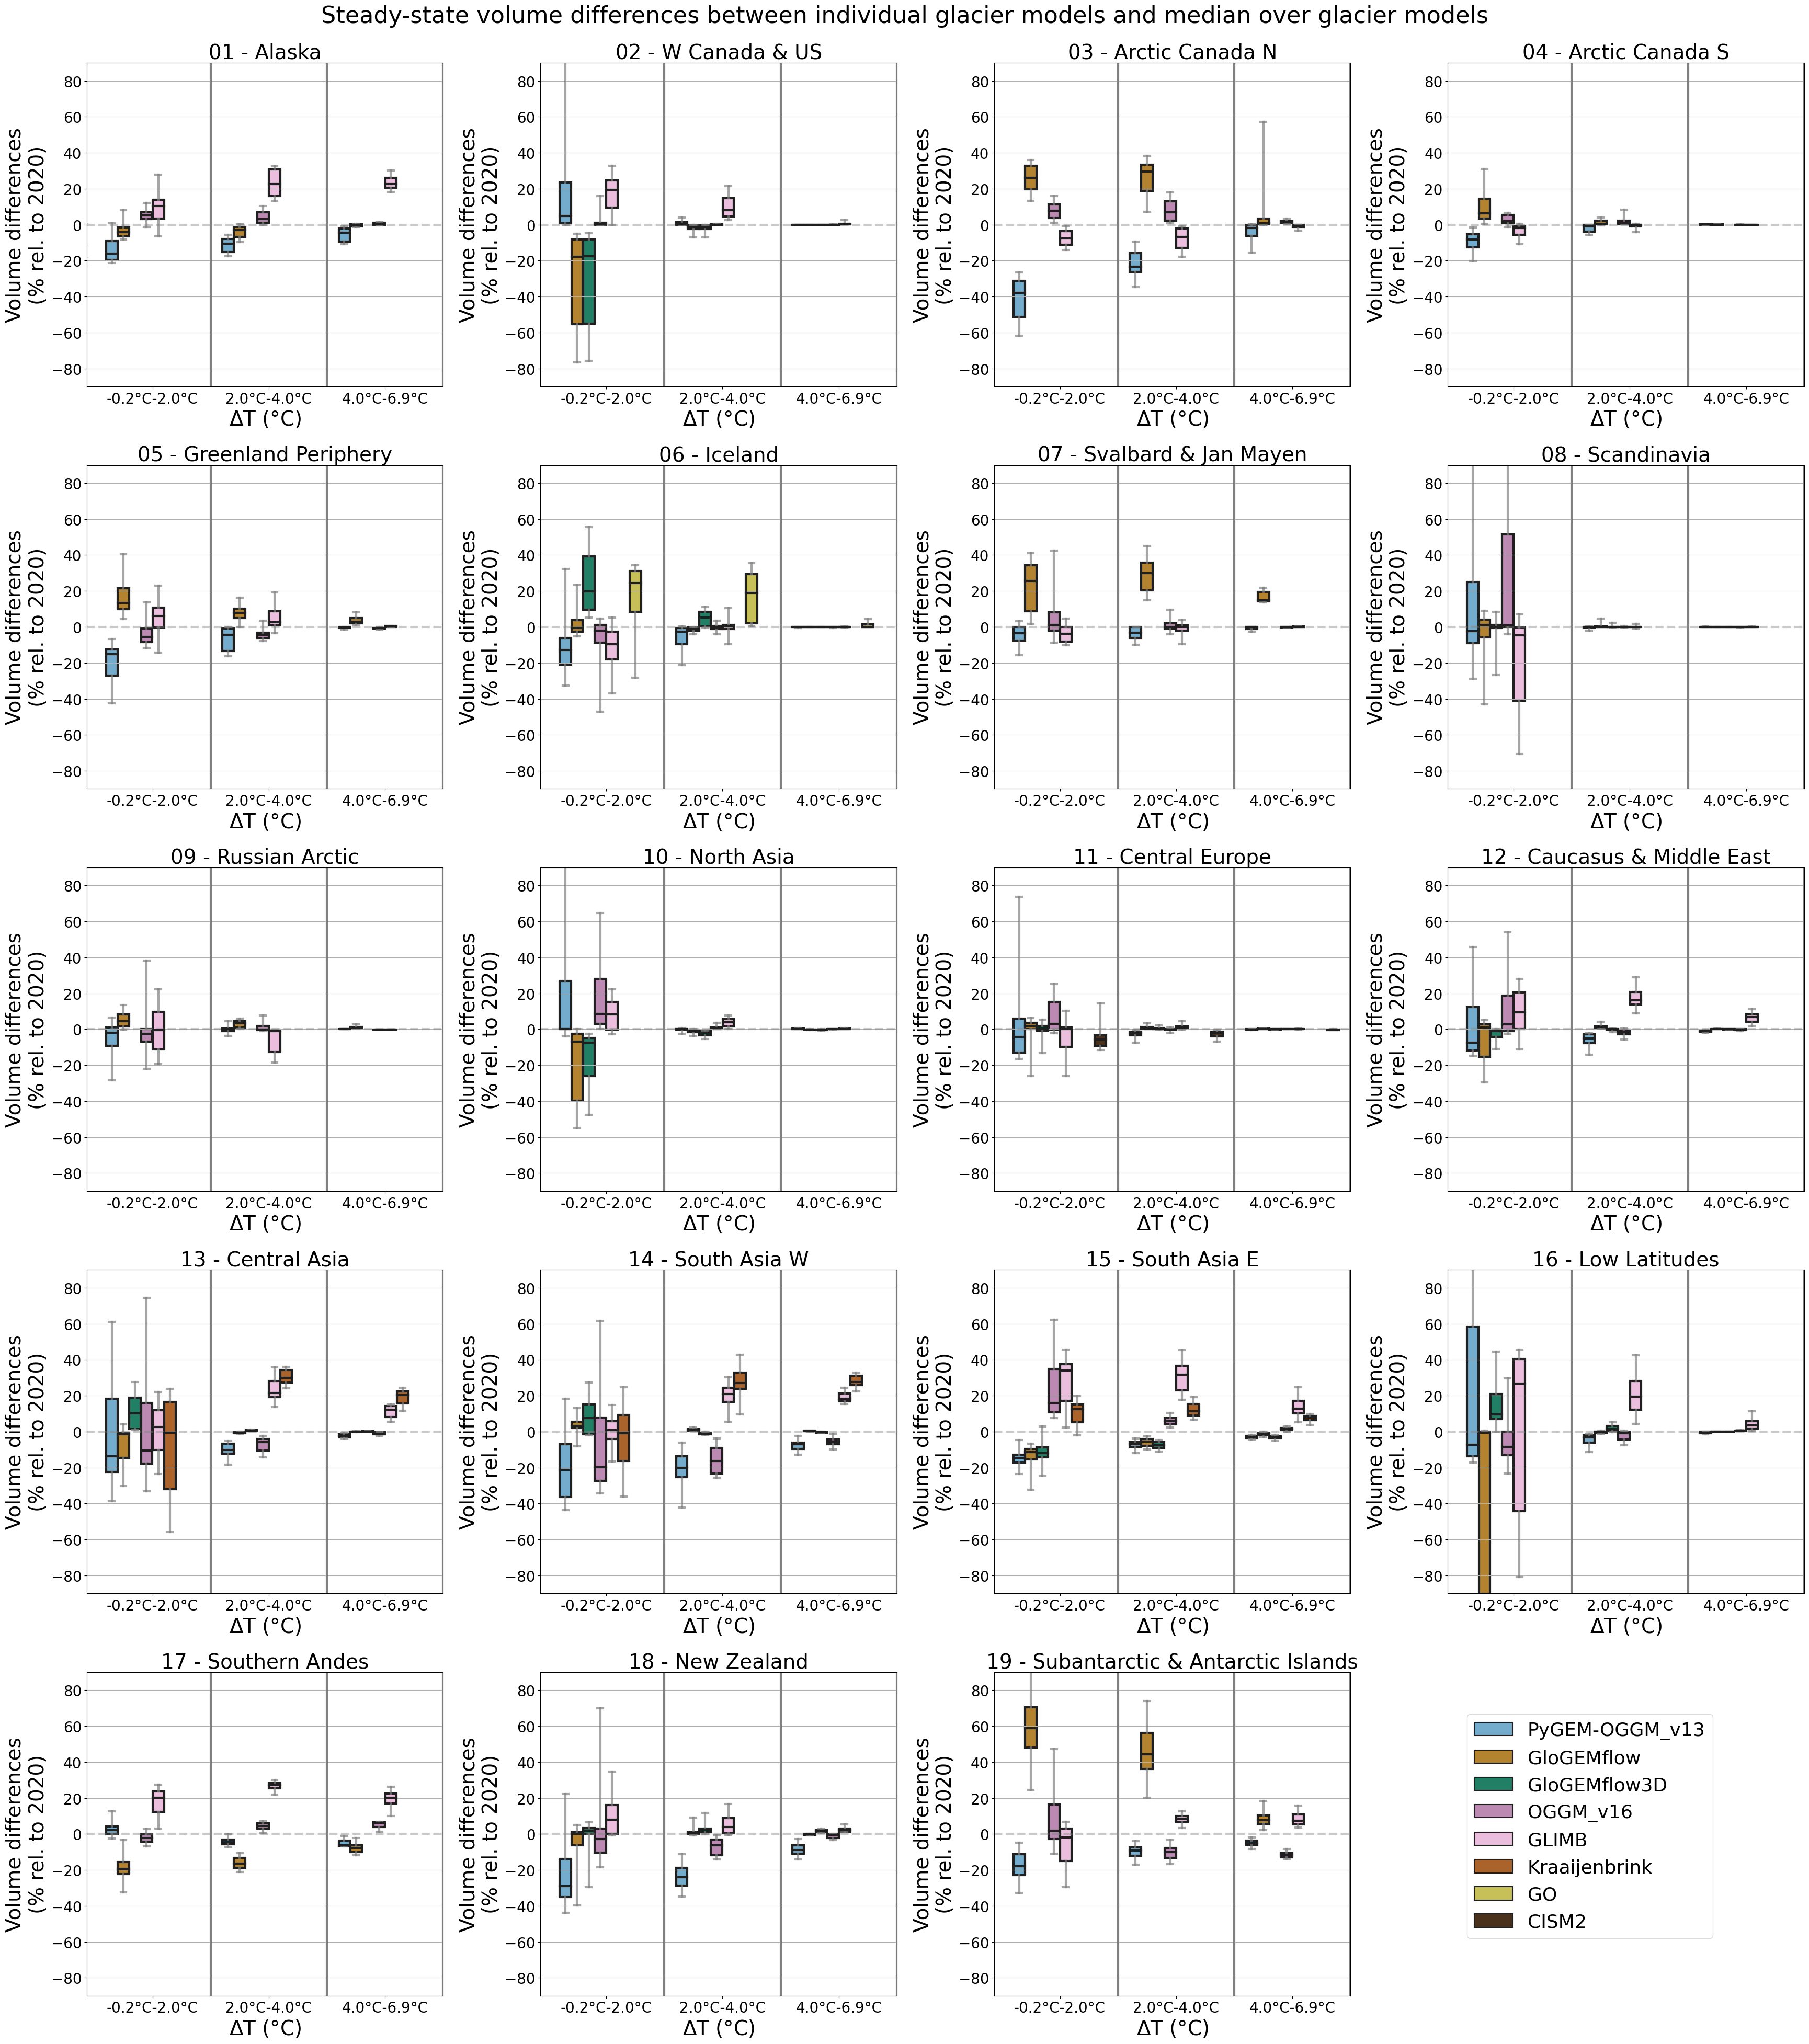

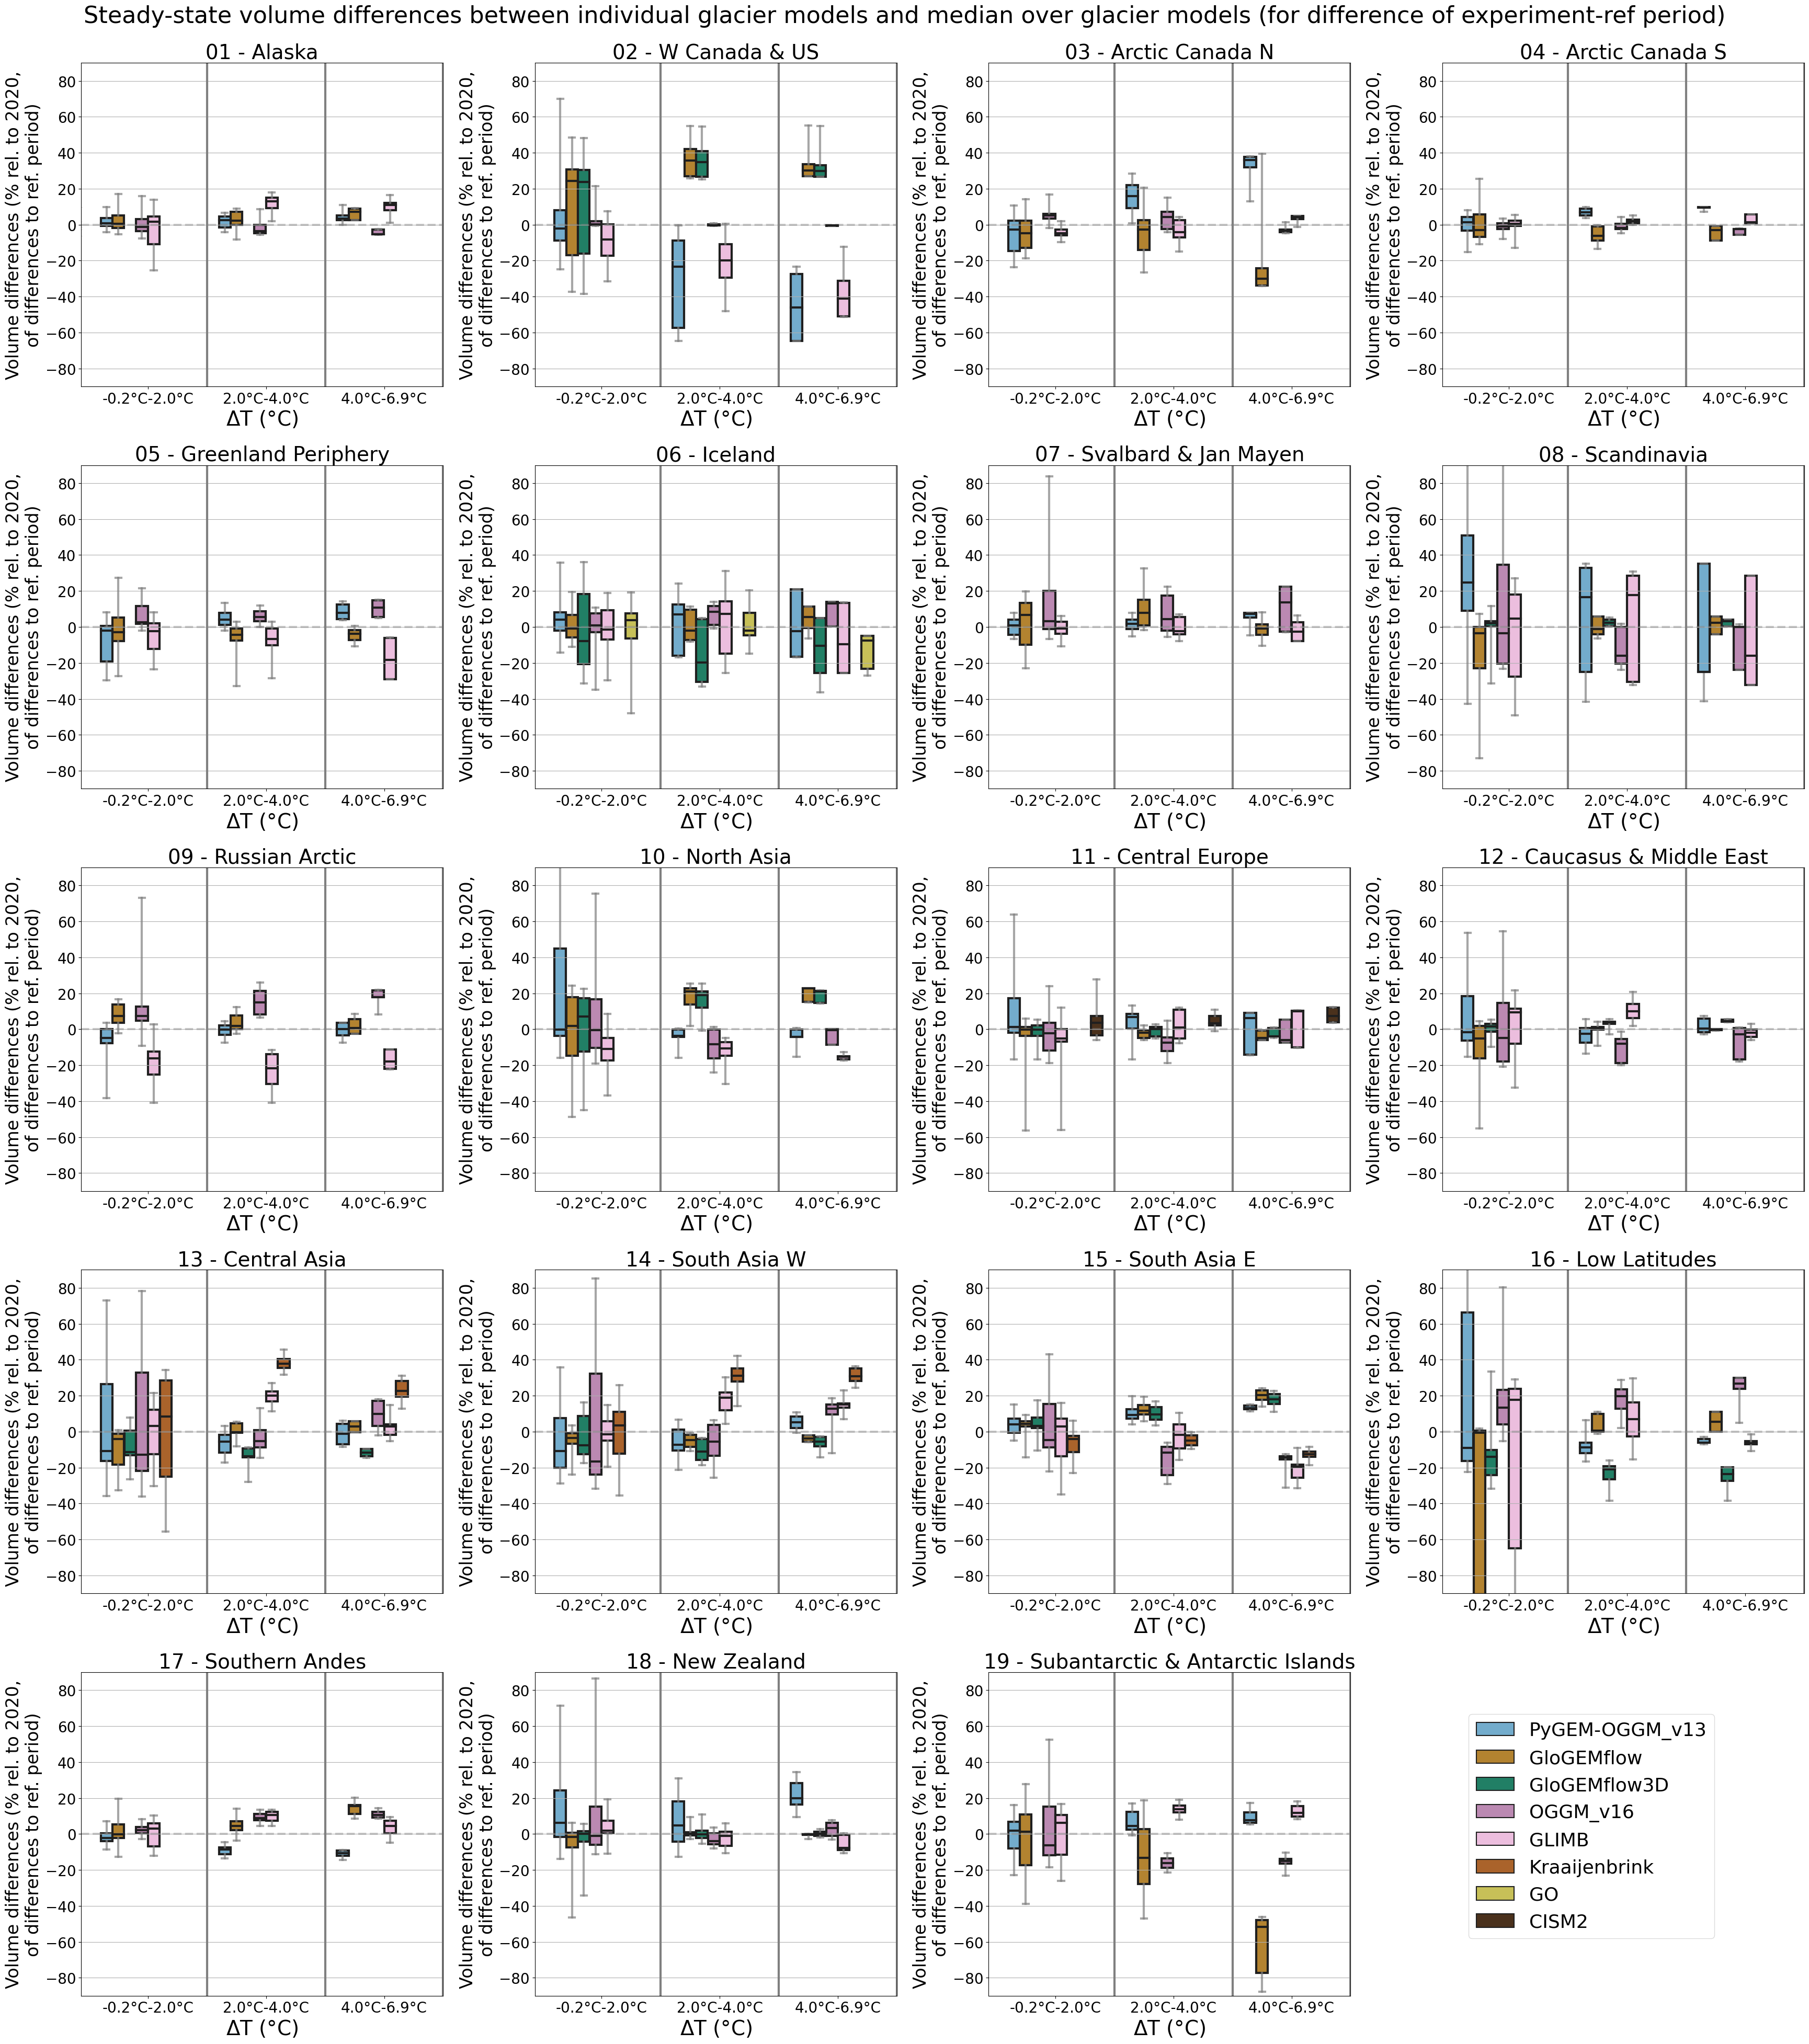

In [66]:
for anonym in ['']: #, '_anonym']:
    if subplots:
        plt.rc('font', size=20)  
        fig1, axs1 = plt.subplots(5,4,figsize=(35,40)) #, sharey=True) #, sharey='row') #, sharex=True)
        suptitle1 = 'Steady-state volume differences between individual glacier models and median over glacier models\n'
        fig1.suptitle(suptitle1, fontsize=32)
        axs1 = axs1.flatten()
        axs1[-1].axis('off')
        
        fig2, axs2 = plt.subplots(5,4,figsize=(35,40)) #, sharey=True) #, sharey='row') #, sharex=True)
        suptitle2 = 'Steady-state volume differences between individual glacier models and median over glacier models (for difference of experiment-ref period)\n'
        fig2.suptitle(suptitle2, fontsize=32)
        axs2 = axs2.flatten()
        axs2[-1].axis('off')

    else:
        plt.rc('font', size=24)  
    for j,rgi_reg in enumerate(pd_reg_models_vol_5000.rgi_reg.unique()):
        rgi_reg_long = f'{rgi_reg} - {d_reg_num_name[rgi_reg]}'

        if not subplots:
            fig, axs = plt.subplots(1,2,figsize=(28,12),sharey=False, sharex=True)
        pd_reg_models_vol_5000_rgi_reg = pd_reg_models_vol_5000.loc[pd_reg_models_vol_5000.rgi_reg==rgi_reg]
        pd_reg_models_vol_5000_no_ref_period_rgi_reg = pd_reg_models_vol_5000_no_ref_period.loc[pd_reg_models_vol_5000_no_ref_period.rgi_reg ==rgi_reg]

        # both together
        ##########
        if subplots:
            ax = axs1[j]
        else:
            ax = axs[0]
        sns.boxplot(data=pd_reg_models_vol_5000_rgi_reg, hue='model_author', y='delta relative volume change (in %, to median model)',
                        x='temp_ch_classes', palette=pal_models, saturation=0.6,
                       hue_order=hue_order, dodge = True, #hue='ssp',
                                            fliersize=0, whis = [5,95], 
                                            #y = 'time', #hue_order = ['2040', '2100'],
                                            linewidth=3,
                                            capprops={'color':'grey', 'alpha':0.7},
                                            whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
        ax.grid(axis='y')
        if shift_years:
            state = '2020'
        else:
            state = 'initial state'
        if not subplots:
            ax.set_title(f'Steady-state volume differences between individual\nglacier models\ and median over glacier models') 
        else:
            ax.set_title(rgi_reg_long, fontsize=28)
        # (for all RGI regions)')  
        #plt.ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=28)
        ax.set_ylabel(f'Volume differences\n(% rel. to {state})', fontsize=28)

        ax.set_xlabel(r'$\Delta$T (°C)', fontsize=28) # , relative to preindustrial)
        for f in np.arange(0.5,3,1):
            ax.axvline(f, color= 'grey', ls='-', lw=3)

        _leg = ax.get_legend()
        handles, labels = ax.get_legend_handles_labels()
        _leg.remove()
        #n = len(hue_order)
        if subplots:
            if j==18:
                fig1.tight_layout()
                if anonym=='_anonym':
                    leg = ax.legend(handles, hue_order_anonymous, #title=f'{n} models',
                                    loc='upper left', framealpha = 0.7, ncol=1, fontsize=26, bbox_to_anchor=(1.3,0.9))
                else:
                    leg = ax.legend(handles, labels, #title=f'{n} models',
                                    loc='upper left', framealpha = 0.7, ncol=1, fontsize=26, bbox_to_anchor=(1.3,0.9))        
        else:
            if anonym=='_anonym':
                leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
            else:
                leg = ax.legend(handles, labels, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)

        qs = pd_reg_models_vol_5000_rgi_reg.groupby(['model_author', 
                                             'temp_ch_classes'])['delta relative volume change (in %, to median model)'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('PyGEM-OGGM_v13',
                                             '-0.2°C-2.0°C')].values
        if (subplots and j == 0) or not subplots: 
            for p,q in enumerate(qs):
                perci = [5,25,50,75,95][p]
                if perci <=75:
                    ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=0)#18)
                else:
                    ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=0)#18)
        xlim0,xlim1 = ax.get_xlim()
        ax.set_xlim([-0.565,xlim1])
        
        ax.axhline(0, lw=3, color='grey', alpha = 0.4, ls='--')
        ax.set_ylim([-90, 90])
        
        #############
        if subplots:
            ax = axs2[j]
        else:
            ax = axs[1]
        sns.boxplot(data=pd_reg_models_vol_5000_no_ref_period_rgi_reg, hue='model_author',
                    y='delta relative volume change (in %, to median model, relative to ref period )',
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},ax=ax)
        ax.grid(axis='y')
        if not subplots:
            ax.set_title('Steady-state volume differences between individual glacier models\nand median over glacier models (for difference of experiment-ref period)')
        else:
            ax.set_title(rgi_reg_long, fontsize=28)
        #plt.ylabel(r'$\Delta$V$_{rel, diff,ref-period}$ (%, difference to median model)', fontsize=26)
        #plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
        #plt.title(f'Steady-state volume differences between individual glacier models\nand median over glacier models (for all RGI regions)')  
        #plt.ylabel(r'$\Delta$V$_{rel}$ (%, difference to median model)', fontsize=28)
        ax.set_ylabel(f'Volume differences (% rel. to {state},\nof differences to ref. period)', fontsize=24)

        ax.set_xlabel(r'$\Delta$T (°C)', fontsize=28) # , relative to preindustrial)

        for f in np.arange(0.5,3,1):
            ax.axvline(f, color= 'grey', ls='-', lw=3)

        _leg = ax.get_legend()
        handles, labels = ax.get_legend_handles_labels()
        _leg.remove()
        #n = len(hue_order)
        if subplots:
            if j==18:
                fig2.tight_layout()
                if anonym=='_anonym':
                    leg = ax.legend(handles, hue_order_anonymous, #title=f'{n} models',
                                    loc='upper left', framealpha = 0.7, ncol=1, fontsize=26, bbox_to_anchor=(1.3,0.9))
                else:
                    leg = ax.legend(handles, labels, #title=f'{n} models',
                                    loc='upper left', framealpha = 0.7, ncol=1, fontsize=26, bbox_to_anchor=(1.3,0.9))        
        else: 
            if anonym=='_anonym':
                leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
            else:
                leg = ax.legend(handles, labels, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        if (subplots and j == 0) or not subplots: 
            
            qs = pd_reg_models_vol_5000_no_ref_period_rgi_reg.groupby(['model_author',
                                                               'temp_ch_classes'])['delta relative volume change (in %, to median model, relative to ref period )'].quantile([0.05,0.25,0.5,0.75,0.95]).loc[('PyGEM-OGGM_v13', '-0.2°C-2.0°C')].values
            for p,q in enumerate(qs):
                perci = [5,25,50,75,95][p]
                if perci <=75:
                    ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=0) #18)
                else:
                    ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=0) #18)
        xlim0,xlim1 = ax.get_xlim()
        ax.set_xlim([-0.565,xlim1])
        if not subplots:
            fig.suptitle(f'{rgi_reg_long}')
            fig.tight_layout()
            fig.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_model_diff_and_diff_to_ref_period_boxplot_5000yrs{anonym}_101yr_avg_period_{rgi_reg}{add}_{DATE}.png')
            plt.close()
        ax.axhline(0, lw=3, color='grey', alpha = 0.4, ls='--')
        ax.set_ylim([-90, 90])

    if subplots:
        #fig1.suptitle(f'{rgi_reg_long}')
        fig1.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_all_regions_model_diff_boxplot_5000yrs{anonym}_101yr_avg_period_{add}_{DATE}.png')
        fig1.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_all_regions_model_diff_boxplot_5000yrs{anonym}_101yr_avg_period_{add}_{DATE}.pdf')

        #fig2.suptitle(f'{rgi_reg_long}')
        fig2.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_all_regions_model_diff_to_ref_period_boxplot_5000yrs{anonym}_101yr_avg_period_{add}_{DATE}.png')
        fig2.savefig(f'figures/3_glacier_model_ss_differences/3_glacier_all_regions_model_diff_to_ref_period_boxplot_5000yrs{anonym}_101yr_avg_period_{add}_{DATE}.pdf')



a

In [75]:
_ds_reg_models_vol_5000 = ds_reg_models_vol_5000.isel(year_after_2020=slice(-100,-1)).mean(dim='year_after_2020')

In [95]:
diff = _ds_reg_models_vol_5000.sel(model_author='GloGEMflow3D')[['relative volume change (in %)','temp_ch_ipcc']] 
diff['relative volume change diff glogems (in %)'] = diff['relative volume change (in %)'] - _ds_reg_models_vol_5000.sel(model_author='GloGEMflow')['relative volume change (in %)']
diff = diff.dropna(dim='rgi_reg')

In [97]:
diff.dropna(dim='rgi_reg').to_dataframe().reset_index()

,rgi_reg,gcm,period_scenario,relative volume change (in %),temp_ch_ipcc,model_author,relative volume change diff glogems (in %)
0,02,gfdl-esm4,1851-1870_hist,26.757049,0.171409,GloGEMflow3D,0.344697
1,02,gfdl-esm4,1901-1920_hist,17.827945,0.418289,GloGEMflow3D,0.194840
2,02,gfdl-esm4,1951-1970_hist,31.347905,0.332281,GloGEMflow3D,0.518795
3,02,gfdl-esm4,1995-2014_hist,22.191419,0.841467,GloGEMflow3D,0.728354
4,02,gfdl-esm4,2021-2040_ssp126,7.809740,1.433792,GloGEMflow3D,0.538611
...,...,...,...,...,...,...,...
875,18,ukesm1-0-ll,2061-2080_ssp370,18.049251,4.379977,GloGEMflow3D,1.155226
876,18,ukesm1-0-ll,2061-2080_ssp585,14.046410,5.170543,GloGEMflow3D,3.055653
877,18,ukesm1-0-ll,2081-2100_ssp126,55.007121,2.978482,GloGEMflow3D,0.755779
878,18,ukesm1-0-ll,2081-2100_ssp370,8.253746,5.780495,GloGEMflow3D,2.104715


<AxesSubplot:xlabel='relative volume change (in %)', ylabel='relative volume change diff glogems (in %)'>

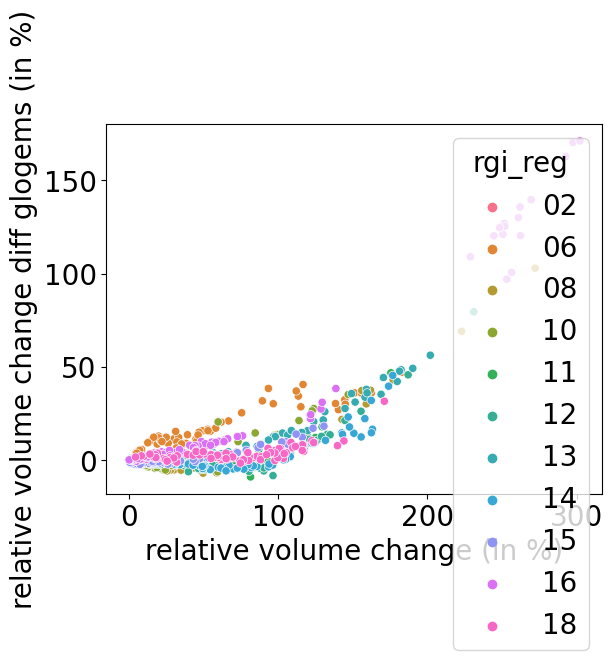

In [102]:
sns.scatterplot(data=diff.to_dataframe().reset_index(),
                x='relative volume change (in %)', y='relative volume change diff glogems (in %)',
            hue='rgi_reg')
                

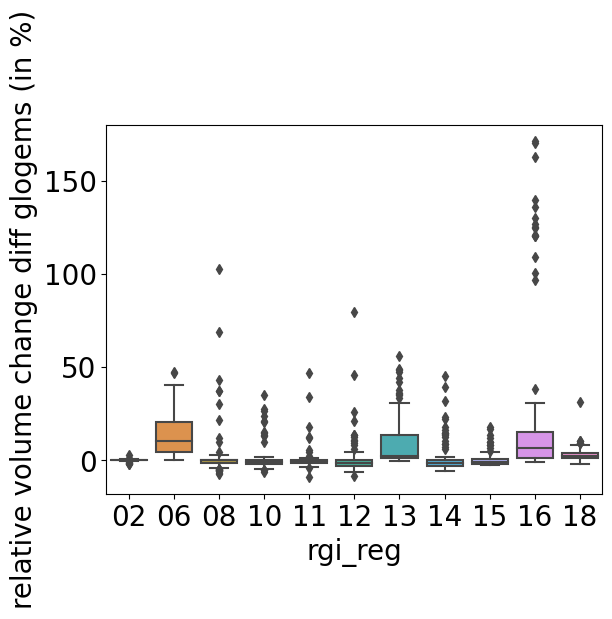

In [105]:
sns.boxplot(data=diff.to_dataframe().reset_index(),
             y='relative volume change diff glogems (in %)',
            x='rgi_reg')
ax = plt.gca()


<AxesSubplot:xlabel='temp_ch_ipcc', ylabel='relative volume change diff glogems (in %)'>

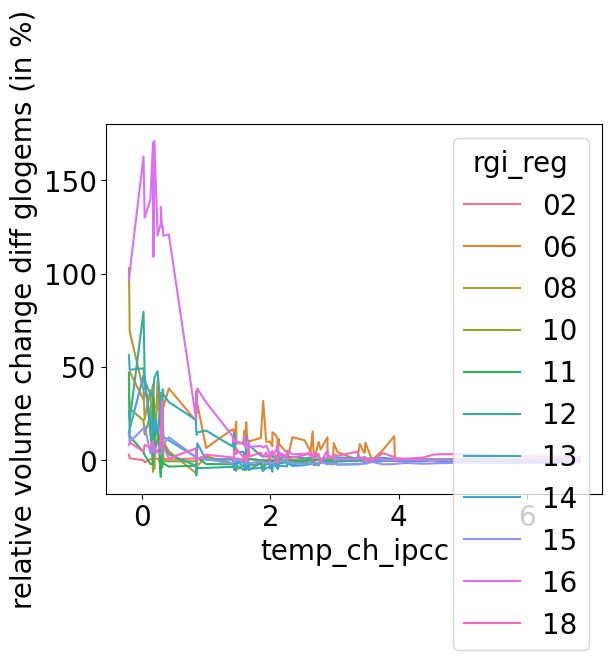

In [100]:
sns.lineplot(data=diff.to_dataframe().reset_index(),
                x='temp_ch_ipcc', y='relative volume change diff glogems (in %)',
            hue='rgi_reg')
                